In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from sklearn.datasets import make_moons

In [58]:
X, y = make_moons(n_samples=250, noise=0.2, random_state=42)

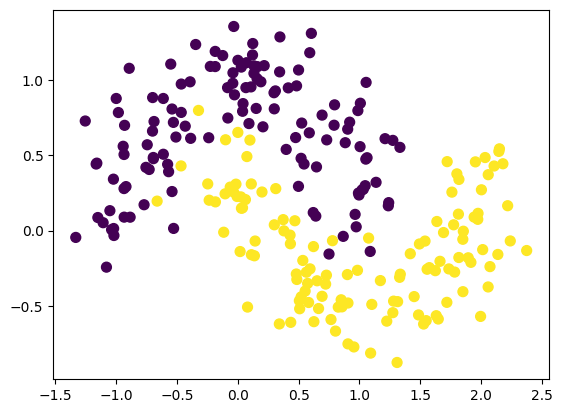

In [59]:
plt.scatter(X[:,0], X[:,1], c=y, s=50)
plt.show()

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [61]:
class weight_init_sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Sigmoid(),
            nn.Linear(in_features=5, out_features=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.linear_stack(x)

model = weight_init_sigmoid().to(device)

In [62]:
model

weight_init_sigmoid(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [63]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[-0.2841,  0.1469],
                      [-0.6447, -0.0622],
                      [-0.4004, -0.2162],
                      [ 0.6523,  0.4869],
                      [ 0.0065,  0.4627]])),
             ('linear_stack.0.bias',
              tensor([ 0.5459,  0.0373, -0.3990,  0.3007,  0.2971])),
             ('linear_stack.2.weight',
              tensor([[-0.1796,  0.0800,  0.3215,  0.3811, -0.0800]])),
             ('linear_stack.2.bias', tensor([0.1557]))])

In [64]:
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

21

In [65]:
# Given weights and biases
weights = [
    torch.tensor([[0., 0.], [0., 0.], [0., 0.], [0., 0.], [0., 0.]], dtype=torch.float32),  # fc1 weight
    torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float32),                 # fc1 bias
    torch.tensor([[0.], [0.]], dtype=torch.float32),           # fc2 weight
    torch.tensor([0.], dtype=torch.float32)                      # fc2 bias
]

In [66]:
weights

[tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 tensor([0., 0., 0., 0., 0.]),
 tensor([[0.],
         [0.]]),
 tensor([0.])]

In [67]:
model.linear_stack[0].weight

Parameter containing:
tensor([[-0.2841,  0.1469],
        [-0.6447, -0.0622],
        [-0.4004, -0.2162],
        [ 0.6523,  0.4869],
        [ 0.0065,  0.4627]], requires_grad=True)

In [68]:
weights[0]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [69]:
model.linear_stack[2].weight

Parameter containing:
tensor([[-0.1796,  0.0800,  0.3215,  0.3811, -0.0800]], requires_grad=True)

In [70]:
weights[1]

tensor([0., 0., 0., 0., 0.])

In [71]:
weights[3]

tensor([0.])

In [72]:
model.linear_stack[2].bias

Parameter containing:
tensor([0.1557], requires_grad=True)

In [73]:
with torch.no_grad():
    model.linear_stack[0].weight.copy_(weights[0])  
    model.linear_stack[0].bias.copy_(weights[1])
    model.linear_stack[2].weight.copy_(weights[1])
    model.linear_stack[2].bias.copy_(weights[3])

# Verify the assigned weights
print("Layer 1 weights:", model.linear_stack[0].weight)
print("Layer 1 bias:", model.linear_stack[0].bias)
print("Layer 2 weights:", model.linear_stack[2].weight)
print("Layer 2 bias:", model.linear_stack[2].bias)

Layer 1 weights: Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)
Layer 1 bias: Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)
Layer 2 weights: Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True)
Layer 2 bias: Parameter containing:
tensor([0.], requires_grad=True)


In [74]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('linear_stack.0.bias', tensor([0., 0., 0., 0., 0.])),
             ('linear_stack.2.weight', tensor([[0., 0., 0., 0., 0.]])),
             ('linear_stack.2.bias', tensor([0.]))])

In [75]:
# loss_fc and optimizer
loss_fc = nn.BCELoss() 

optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.001)

In [76]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [77]:
# building a training and evaluation loop

epochs = 100

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y)


# lets print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}")

Epoch: 0 | Loss: 0.69315
Epoch: 10 | Loss: 0.69315
Epoch: 20 | Loss: 0.69315
Epoch: 30 | Loss: 0.69311
Epoch: 40 | Loss: 0.69296
Epoch: 50 | Loss: 0.69264
Epoch: 60 | Loss: 0.69212
Epoch: 70 | Loss: 0.69139
Epoch: 80 | Loss: 0.69042
Epoch: 90 | Loss: 0.68922


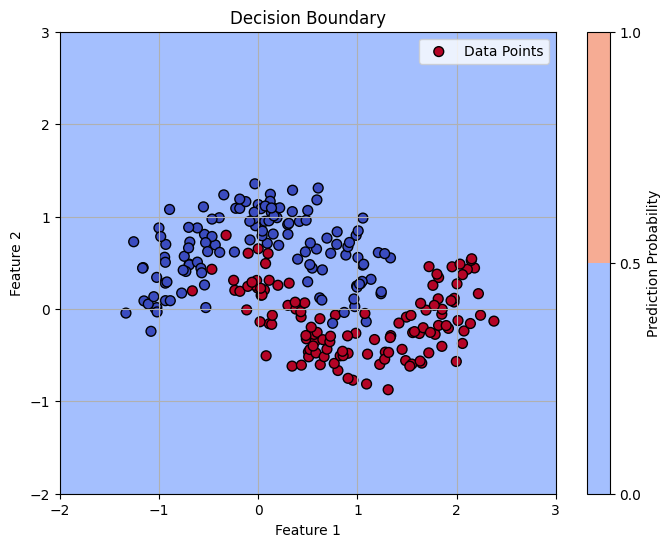

In [84]:
# 1. Generate a grid of points
x1_range = np.linspace(-2.0, 3.0, 200)
x2_range = np.linspace(-2.0, 3.0, 200)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# 2. Predict probabilities for the grid points
with torch.no_grad():
    grid_preds = model(grid_tensor).numpy()

# 3. Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, grid_preds.reshape(x1_grid.shape), levels=[0, 0.5, 1], alpha=0.8, cmap='coolwarm')
plt.colorbar(label='Prediction Probability')

# 4. Overlay the data points
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolor='k', cmap='coolwarm', s=50, label='Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.legend()
plt.grid()
plt.show()

- In case of sigmoid if we initialize the weight and bias with zero then it act as linear model and not able to capture the non linearity in the model
- means if we add as much as neurons in the hidden layers it only act like a single neuron

In [79]:
model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[-0.1269,  0.1265],
                      [-0.1269,  0.1265],
                      [-0.1269,  0.1265],
                      [-0.1269,  0.1265],
                      [-0.1269,  0.1265]])),
             ('linear_stack.0.bias',
              tensor([-0.1387, -0.1387, -0.1387, -0.1387, -0.1387])),
             ('linear_stack.2.weight',
              tensor([[-0.1013, -0.1013, -0.1013, -0.1013, -0.1013]])),
             ('linear_stack.2.bias', tensor([0.1223]))])